# Event-based Visual Microphone

### Purpose
This notebook is designed to extract audible sounds from a video of an object vibrating in response to those sounds. The process begins with the transformation of a standard RGB video into an event video. This step is necessary because an event camera was not available at the time of this project. Following the transformation, the event video is then processed to recover sound.

### Objectives
- To break a RGB video into segments.
- To convert the RGB videos to event videos, using a v2e toolbox inspired simulator.
- To convert the event videos to sound using Abe Davis' Visual Microphone method.
- To use a bandwidth extension model to enhance the recovered sound.
- To visualise the recovered signal.

### Dependencies
To run this notebook, you will need the following libraries:
- `cv2`: OpenCV
- `numpy` : NumPy
- `scipy` : SciPy
- `torch` : PyTorch
- `librosa` : Librosa
- `tensorflow` : TensorFlow
- `matplotlib` : Matplotlib
- `soundfile` : Soundfile
- `sounddevice` : Sounddevice

In [1]:
import utilities.video_frames as frames
import event_camera.simulator_utils as camera
import steerable_pyramid.davis_method as pyramid

## Break RGB video into segments
The code bellow assess the video size and breaks it into 2GB segments. The videos are stored in a tempory folder in Documents, which is then deleted automatically at the end.

<span style="color:red"> Enter the input video file path and fps bellow: </span>

In [2]:
framerate = 2000
video_path = '/Volumes/Omkar 5T/dataset/haoqi_events_mp4/p230_002_mic1.mp4'

In [ ]:
frames.extract_video_segments(video_path)

## Convert RGB video to event video
This process uses a v2e toolbox inspired model created by Tobi Delbruck, Yuhuang Hu and Zhe He. The only difference is that our model doesn't include event noise. There are two important variables:
- **Cut-off frequency** (`cutoff_freq`): for event pixel bandwidth: more information can be extracted at lower frequencies. This makes it perfect for low light conditions.
- **+/-ve thresholds** (`pos_thresh` and `neg_thresh`) : completely based on cut-off frequency and the maximum allowable events for any pixel.

### Ideal paramters for Visual Microphone dataset
For the slow-motion RGB videos from Abe Davis' Visual Microphone dataset, the ideal parameters are:
- MIDI Chips Bag: `3e-4` cutoff-freq, `8e-7` pos_thresh and `8e-7` neg_thresh
- MIDI Plants: `3e-5` cutoff-freq, `9e-8` pos_thresh and `9e-8` neg_thresh
- Speech Chips Bag 2.2kHz: `3e-4` cutoff-freq, `7e-7` pos_thresh and `7e-7` neg_thresh
- Speech Chips Bag 20kHz: `3e-6` cutoff-freq, `7e-10` pos_thresh and `7e-10` neg_thresh

<span style="color:red"> Enter the simulation parameters bellow: </span>

In [ ]:
cutoff_freq = 3e1
pos_thresh = 6e-2
neg_thresh = 6e-2

In [ ]:
video_fps = 30
sampling_period = 1/video_fps
camera.event_simulator(sampling_period, cutoff_freq, pos_thresh, neg_thresh)

The code bellow allows to see the event video after conversion.

In [ ]:
camera.show_video()

This code bellow allows to save the event video.

<span style="color:red"> Make `save_vid` 1 to save the video or 0 otherwise and specify save path: </span>

In [ ]:
save_vid = 1
video_save_path = '/Volumes/Omkar 5T/plants.mp4'

In [ ]:
camera.save_video(save_vid, video_save_path, framerate)

## Convert event video to sound

This step uses a phase-based method. The method applies a steerable pyramid to get a phase response at several scales and orientations. Then several steps are applied to flatten and average the response to a time-series signal. The important parameters for this process are:
- **Number of Scales** (`nscales`): defines the number of levels of the pyramid. For visual microphone this was set to 2.
- **Number of Orientations** (`norientations`): defines the number of steerable filters at a level of the pyramid. For visual microphone this was set to 4.

<span style="color:red"> Enter the steerable pyramid parameters and recovered sound file path bellow: </span>

In [3]:
nscales = 2
norientations = 4
save_path = '/Volumes/Omkar 5T/vid1.wav'

This step takes several hours, traditionally 2hrs.

In [4]:
import cv2
import numpy as np
import soundfile as sf

def load_video(video_path):
    video_frames = []
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = gray_frame.astype(np.float32) / 255.0
        video_frames.append(gray_frame)
    cap.release()
    video_frames = np.array(video_frames)
    return video_frames

Progress: 0.013491635186184566% done after 0.04555916786193848 seconds.
Progress: 1.0118726389638424% done after 2.9625701904296875 seconds.
Progress: 2.0102536427415005% done after 5.868486166000366 seconds.
Progress: 3.008634646519158% done after 8.693857192993164 seconds.
Progress: 4.007015650296816% done after 11.533522367477417 seconds.
Progress: 5.005396654074474% done after 14.359336376190186 seconds.
Progress: 6.003777657852131% done after 17.20624828338623 seconds.
Progress: 7.00215866162979% done after 20.022529125213623 seconds.
Progress: 8.000539665407446% done after 22.84616708755493 seconds.
Progress: 8.998920669185106% done after 25.659775018692017 seconds.
Progress: 9.997301672962763% done after 28.472346305847168 seconds.
Progress: 10.99568267674042% done after 31.304036140441895 seconds.
Progress: 11.994063680518078% done after 34.16272735595703 seconds.
Progress: 12.992444684295737% done after 37.01462125778198 seconds.
Progress: 13.990825688073393% done after 39.842

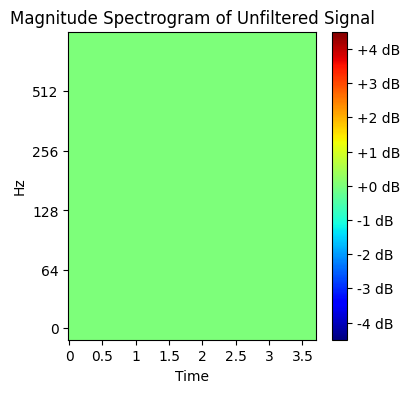

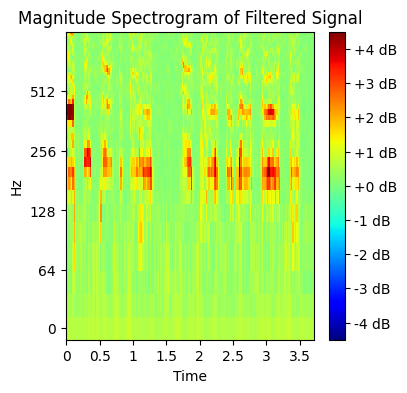

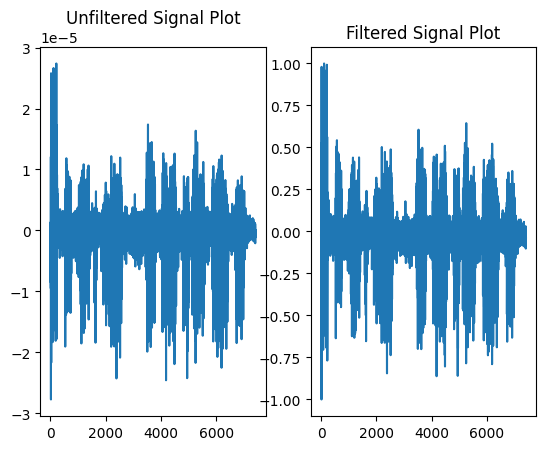

In [5]:
# pyramid.ebvmSoundfromVideo(save_path, nscales, norientations, framerate)
video = load_video(video_path)
Sx = pyramid.vmSoundFromVideo(video, nscales, norientations, framerate)
sf.write(save_path, Sx, framerate)